# Boilerplate

In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from src.libraries import *
from random_forest import VanillaRandomForest
from utils import find_node_dir_val, plot_2d_grids_from_fitted_rf
from metrics.classification import *

# Test Runs

## Sklearn dataset - Breast Cancer

In [3]:
sklearn_data = load_breast_cancer()
X, y = sklearn_data.data, sklearn_data.target
sklearn_datadf = pd.DataFrame(X)
sklearn_datadf['y'] = y

In [4]:
# Train test split, random 75-25% splits

sklearn_datadf_train = sklearn_datadf.sample(frac=0.75, random_state=10)

test_idx = [i for i in range(len(sklearn_datadf)) if i not in sklearn_datadf_train.index]
sklearn_datadf_test = sklearn_datadf.iloc[test_idx, :]
sklearn_datadf_test.reset_index(drop=True, inplace=True)

In [5]:
rf = VanillaRandomForest(
    n_trees = 25, 
    target='y',
    max_depth=3,
    min_leaf_size=1, 
    frac_max_features = 0.8,
    bootstrap = True,
    random_state=10
)

In [6]:
rf.fit(sklearn_datadf_train)

Training tree number 0
Training tree number 1
Training tree number 2
Training tree number 3
Training tree number 4
Training tree number 5
Training tree number 6
Training tree number 7
Training tree number 8
Training tree number 9
Training tree number 10
Training tree number 11
Training tree number 12
Training tree number 13
Training tree number 14
Training tree number 15
Training tree number 16
Training tree number 17
Training tree number 18
Training tree number 19
Training tree number 20
Training tree number 21
Training tree number 22
Training tree number 23
Training tree number 24


In [8]:
test_preds = rf.predict(sklearn_datadf_test)

In [29]:
fprs, tprs, thresholds = roc_curve_scratch(sklearn_datadf_test['y'], np.array(test_preds))

In [30]:
auc_scratch(fprs, tprs)

0.9757478632478633

# Comparison with Sklearn's implementation

In [31]:
skrf = RandomForestClassifier(
    n_estimators=25,
    bootstrap=True,
    max_features=0.8,
    max_depth=3,
    min_samples_leaf=1
)

In [32]:
skrf.fit(sklearn_datadf_train.drop('y', axis=1), sklearn_datadf_train['y'])

RandomForestClassifier(max_depth=3, max_features=0.8, n_estimators=25)

In [33]:
test_preds_sk = skrf.predict_proba(sklearn_datadf_test.drop('y', axis=1))[:,1]
fprs_sk, tprs_sk, _ = roc_curve(sklearn_datadf_test['y'], test_preds_sk)

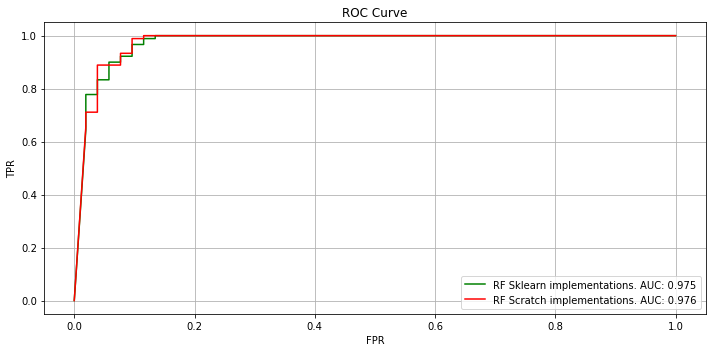

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(fprs_sk, tprs_sk, label= f'RF Sklearn implementations. AUC: {auc(fprs_sk, tprs_sk):0.3f}', color='g')
ax.plot(fprs, tprs, label= f'RF Scratch implementations. AUC: {auc_scratch(fprs, tprs):0.3f}', color='r')

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC Curve')
ax.grid()
ax.legend()
fig.tight_layout()

Compared to decision tree clasifier, random forst (both scratch and sklearn are higher performant)

# Visualization of Random Forest on 2D Data

Visualization ideas are taken from ex masters classmate Tyler's blogpost: http://structuringtheunstructured.blogspot.com/2017/11/coloring-with-random-forests.htmlm

In [35]:
sim_df = pd.DataFrame()
sim_df['x'] = np.random.uniform(0, 100, size=1000)
sim_df['y'] = np.random.uniform(0, 100, size=1000)
sim_df['class'] = 0

In [36]:
# circle #1 
xoffset = 20 # x distance of center from origin
yoffset = 20 # y distance of center from origin
r = 10 # radius

sim_df.loc[((sim_df['x'] - xoffset)**2 +\
            (sim_df['y'] - yoffset)**2) < r**2 
           , 'class'] = 1

# circle #2
xoffset = 50 # x distance of center from origin
yoffset = 80 # y distance of center from origin
r = 15 # radius

sim_df.loc[((sim_df['x'] - xoffset)**2 +\
            (sim_df['y'] - yoffset)**2) < r**2 
           , 'class'] = 1


# circle #3
xoffset = 80 # x distance of center from origin
yoffset = 20 # y distance of center from origin
r = 10 # radius

sim_df.loc[((sim_df['x'] - xoffset)**2 +\
            (sim_df['y'] - yoffset)**2) < r**2 
           , 'class'] = 1

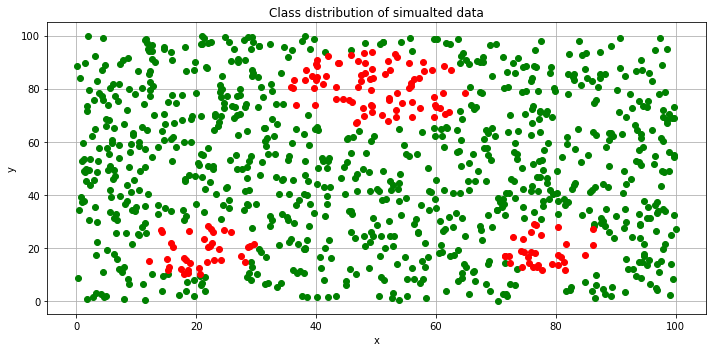

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    sim_df[sim_df['class'] == 0]['x'], 
    sim_df[sim_df['class'] == 0]['y'], 
    'o',
    color='g')
ax.plot(
    sim_df[sim_df['class'] == 1]['x'], 
    sim_df[sim_df['class'] == 1]['y'], 
    'o',
    color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Class distribution of simualted data')
ax.grid()
# ax.legend()
fig.tight_layout()

In [38]:
rf = VanillaRandomForest(
    n_trees = 10, 
    target='class',
    max_depth=3,
    min_leaf_size=4, 
    frac_max_features = 0.4,
    bootstrap = True,
    random_state=10
)

In [39]:
rf.fit(sim_df)

Training tree number 0
Training tree number 1
Training tree number 2
Training tree number 3
Training tree number 4
Training tree number 5
Training tree number 6
Training tree number 7
Training tree number 8
Training tree number 9


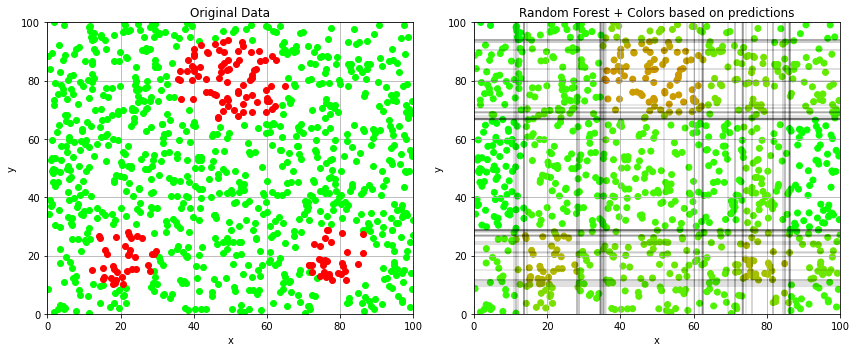

In [43]:
preds = rf.predict(sim_df)
plot_2d_grids_from_fitted_rf(rf, sim_df.copy(), preds, n_trees=10, alpha=0.01)

At same depth and min_samples_leaf, Random Forest is better able to classify real red as darker color as compared to decision tree should at the end of VanillaDecisionTreeClassifierExample notebook, where the decision tree has more false green at bottom side. Random forest is able to do that by building N diverse trees and taking average of predictions from each tree

# End